In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
y = y.astype(int)
X = ((X / 255) - 0.5) * 2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, random_state=123, stratify=y)

In [3]:
import numpy as np
import sys

## Sigmoid

In [5]:
class MLP(object):
    
    def __init__(self, n_hidden=30, n_hidden2=30,
                 l2=0., epochs=100, minibatch_size=1, eta=0.001,
                 shuffle=True, seed=None):

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.n_hidden2 = n_hidden2
        self.l2 = l2
        self.epochs = epochs
        self.minibatch_size = minibatch_size
        self.eta = eta
        self.shuffle = shuffle

    def _onehot(self, y, n_classes):
        
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, z):

        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def _forward(self, X):

        z_h = np.dot(X, self.w_h) + self.b_h

        a_h = self._sigmoid(z_h)
        
        z_h2 = np.dot(a_h, self.w_h2) + self.b_h2
        
        a_h2 = self._sigmoid(z_h2)

        z_out = np.dot(a_h2, self.w_out) + self.b_out

        a_out = self._sigmoid(z_out)

        return z_h, a_h, z_h2, a_h2, z_out, a_out

    def _cost(self, y_enc, output):

        cost = np.sum(-y_enc * (np.log(output)) - (1. - y_enc) * np.log(1. - output)) + \
                      self.l2 * (np.sum(self.w_h ** 2.) + np.sum(self.w_h2 ** 2.) + np.sum(self.w_out ** 2.))

        return cost

    def predict(self, X):
        
        z_h, a_h, z_h2, a_h2, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        
        n_output = np.unique(y_train).shape[0]
        n_features = X_train.shape[1]

        # Weight initialization

        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1, size=(n_features, self.n_hidden))
        
        self.b_h2 = np.zeros(self.n_hidden2)
        self.w_h2 = self.random.normal(loc=0.0, scale=0.1, size=(self.n_hidden, self.n_hidden2))

        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1, size=(self.n_hidden2, n_output))

        epoch_strlen = len(str(self.epochs))
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        y_train_enc = self._onehot(y_train, n_output)

        for i in range(self.epochs):

            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # forward propagation
                z_h, a_h, z_h2, a_h2, z_out, a_out = self._forward(X_train.iloc[batch_idx])

                # Backpropagation

                delta_out = a_out - y_train_enc[batch_idx]

                sigmoid_derivative_h = a_h * (1. - a_h)
                
                sigmoid_derivative_h2 = a_h2 * (1. - a_h2)

                delta_h2 = (np.dot(delta_out, self.w_out.T) * sigmoid_derivative_h2)
                
                delta_h = (np.dot(delta_h2, self.w_h2.T) * sigmoid_derivative_h)

                grad_w_h = np.dot(X_train.iloc[batch_idx].T, delta_h)
                grad_b_h = np.sum(delta_h, axis=0)
                
                grad_w_h2 = np.dot(a_h.T, delta_h2)
                grad_b_h2 = np.sum(delta_h2, axis=0)

                grad_w_out = np.dot(a_h2.T, delta_out)
                grad_b_out = np.sum(delta_out, axis=0)

                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h
                
                delta_w_h2 = (grad_w_h2 + self.l2*self.w_h2)
                delta_b_h2 = grad_b_h2
                
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h
                
                self.w_h2 -= self.eta * delta_w_h2
                self.b_h2 -= self.eta * delta_b_h2

                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out

            # Evaluation

            z_h, a_h, z_h2, a_h2, z_out, a_out = self._forward(X_train)
            
            cost = self._cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) / X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) / X_valid.shape[0])

            sys.stdout.write('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost, train_acc*100, valid_acc*100))
            sys.stdout.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

In [6]:
nn = MLP(n_hidden=128, n_hidden2=64, l2=0.05, epochs=100, minibatch_size=100, eta=0.0005, shuffle=True, seed=1)

In [7]:
%%time
nn.fit(X_train[:55000], y_train[:55000], X_train[55000:], y_train[55000:])

2/2 | Cost: 80471.88 | Train/Valid Acc.: 81.66%/81.22%  Wall time: 10.2 s


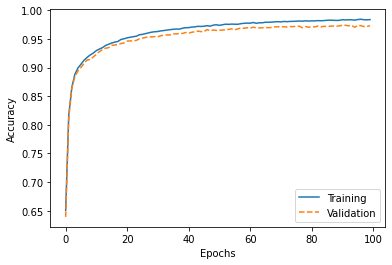

In [7]:
import matplotlib.pyplot as plt
plt.plot(range(nn.epochs), nn.eval_['train_acc'], 
         label='Training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], 
         label='Validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

In [8]:
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test == y_test_pred).astype(np.float) / X_test.shape[0])

print('Test accuracy: %.2f%%' % (acc * 100))

Test accuracy: 97.09%


## ReLU

In [17]:
import numpy as np
import sys

class MLP(object):
    
    def __init__(self, n_hidden=30, n_hidden2=30,
                 l2=0., epochs=100, minibatch_size=1, eta=0.001,
                 shuffle=True, seed=None):

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.n_hidden2 = n_hidden2
        self.l2 = l2
        self.epochs = epochs
        self.minibatch_size = minibatch_size
        self.eta = eta
        self.shuffle = shuffle

    def _onehot(self, y, n_classes):
        
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

    def _ReLU(self, z):

        return np.maximum(np.clip(z, -250, 250), 0)

    def _forward(self, X):

        z_h = np.dot(X, self.w_h) + self.b_h

        a_h = self._ReLU(z_h)
        
        z_h2 = np.dot(a_h, self.w_h2) + self.b_h2
        
        a_h2 = self._ReLU(z_h2)

        z_out = np.dot(a_h2, self.w_out) + self.b_out

        a_out = self._ReLU(z_out)

        return z_h, a_h, z_h2, a_h2, z_out, a_out

    def _cost(self, y_enc, output):

        cost = np.sum((y_enc - output)**2) + \
                      self.l2 * (np.sum(self.w_h ** 2.) + np.sum(self.w_h2 ** 2.) + np.sum(self.w_out ** 2.))

        return cost

    def predict(self, X):
        
        z_h, a_h, z_h2, a_h2, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        
        n_output = np.unique(y_train).shape[0]
        n_features = X_train.shape[1]

        # Weight initialization

        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1, size=(n_features, self.n_hidden))
        
        self.b_h2 = np.zeros(self.n_hidden2)
        self.w_h2 = self.random.normal(loc=0.0, scale=0.1, size=(self.n_hidden, self.n_hidden2))

        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1, size=(self.n_hidden2, n_output))

        epoch_strlen = len(str(self.epochs))
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        y_train_enc = self._onehot(y_train, n_output)

        for i in range(self.epochs):

            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # forward propagation
                z_h, a_h, z_h2, a_h2, z_out, a_out = self._forward(X_train.iloc[batch_idx])

                # Backpropagation

                delta_out = a_out - y_train_enc[batch_idx]

                ReLU_derivative_h = np.maximum(a_h, 0) / np.maximum(a_h, 1)
                
                ReLU_derivative_h2 = np.maximum(a_h2, 0) / np.maximum(a_h2, 1)

                delta_h2 = (np.dot(delta_out, self.w_out.T) * ReLU_derivative_h2)
                
                delta_h = (np.dot(delta_h2, self.w_h2.T) * ReLU_derivative_h)

                grad_w_h = np.dot(X_train.iloc[batch_idx].T, delta_h)
                grad_b_h = np.sum(delta_h, axis=0)
                
                grad_w_h2 = np.dot(a_h.T, delta_h2)
                grad_b_h2 = np.sum(delta_h2, axis=0)

                grad_w_out = np.dot(a_h2.T, delta_out)
                grad_b_out = np.sum(delta_out, axis=0)

                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h
                
                delta_w_h2 = (grad_w_h2 + self.l2*self.w_h2)
                delta_b_h2 = grad_b_h2
                
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h
                
                self.w_h2 -= self.eta * delta_w_h2
                self.b_h2 -= self.eta * delta_b_h2

                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out

            # Evaluation

            z_h, a_h, z_h2, a_h2, z_out, a_out = self._forward(X_train)
            
            cost = self._cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) / X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) / X_valid.shape[0])

            sys.stdout.write('\r%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (i+1, cost, train_acc*100, valid_acc*100))
            sys.stdout.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

In [18]:
nn = MLP(n_hidden=128, n_hidden2=64, l2=0.05, epochs=2, minibatch_size=100, eta=0.0005, shuffle=True, seed=1)

In [19]:
%%time
nn.fit(X_train[:55000], y_train[:55000], X_train[55000:], y_train[55000:])

2 | Cost: 11305.39 | Train/Valid Acc.: 89.65%/89.32% Wall time: 10.3 s


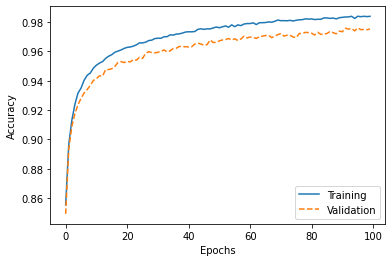

In [12]:
import matplotlib.pyplot as plt
plt.plot(range(nn.epochs), nn.eval_['train_acc'], 
         label='Training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], 
         label='Validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

In [13]:
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test == y_test_pred).astype(np.float) / X_test.shape[0])

print('Test accuracy: %.2f%%' % (acc * 100))

Test accuracy: 97.32%


## ReLU + Adam

In [14]:
import numpy as np
import sys

class MLP(object):
    
    def __init__(self, n_hidden=30, n_hidden2=30,
                 l2=0., epochs=100, minibatch_size=1, eta=0.001,
                 shuffle=True, seed=None, beta1=0.9, beta2=0.999, epsilon=1e-7):

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.n_hidden2 = n_hidden2
        self.l2 = l2
        self.epochs = epochs
        self.minibatch_size = minibatch_size
        self.eta = eta
        self.shuffle = shuffle
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m_dw_h, self.v_dw_h = 0, 0
        self.m_db_h, self.v_db_h = 0, 0
        self.m_dw_h2, self.v_dw_h2 = 0, 0
        self.m_db_h2, self.v_db_h2 = 0, 0
        self.m_dw_out, self.v_dw_out = 0, 0
        self.m_db_out, self.v_db_out = 0, 0

    def _onehot(self, y, n_classes):
        
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

    def _ReLU(self, z):

        return np.maximum(np.clip(z, -250, 250), 0)

    def _forward(self, X):

        z_h = np.dot(X, self.w_h) + self.b_h

        a_h = self._ReLU(z_h)
        
        z_h2 = np.dot(a_h, self.w_h2) + self.b_h2
        
        a_h2 = self._ReLU(z_h2)

        z_out = np.dot(a_h2, self.w_out) + self.b_out

        a_out = self._ReLU(z_out)

        return z_h, a_h, z_h2, a_h2, z_out, a_out

    def _cost(self, y_enc, output):

        cost = np.sum((y_enc - output)**2) + \
                      self.l2 * (np.sum(self.w_h ** 2.) + np.sum(self.w_h2 ** 2.) + np.sum(self.w_out ** 2.))

        return cost

    def predict(self, X):
        
        z_h, a_h, z_h2, a_h2, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        
        n_output = np.unique(y_train).shape[0]
        n_features = X_train.shape[1]

        # Weight initialization

        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1, size=(n_features, self.n_hidden))
        
        self.b_h2 = np.zeros(self.n_hidden2)
        self.w_h2 = self.random.normal(loc=0.0, scale=0.1, size=(self.n_hidden, self.n_hidden2))

        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1, size=(self.n_hidden2, n_output))

        epoch_strlen = len(str(self.epochs))
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        y_train_enc = self._onehot(y_train, n_output)

        for i in range(self.epochs):

            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # forward propagation
                z_h, a_h, z_h2, a_h2, z_out, a_out = self._forward(X_train.iloc[batch_idx])

                # Backpropagation

                delta_out = a_out - y_train_enc[batch_idx]

                ReLU_derivative_h = np.maximum(a_h, 0) / np.maximum(a_h, 1)
                
                ReLU_derivative_h2 = np.maximum(a_h2, 0) / np.maximum(a_h2, 1)

                delta_h2 = (np.dot(delta_out, self.w_out.T) * ReLU_derivative_h2)
                
                delta_h = (np.dot(delta_h2, self.w_h2.T) * ReLU_derivative_h)

                grad_w_h = np.dot(X_train.iloc[batch_idx].T, delta_h)
                grad_b_h = np.sum(delta_h, axis=0)
                
                grad_w_h2 = np.dot(a_h.T, delta_h2)
                grad_b_h2 = np.sum(delta_h2, axis=0)

                grad_w_out = np.dot(a_h2.T, delta_out)
                grad_b_out = np.sum(delta_out, axis=0)

                self.m_dw_out = self.beta1*self.m_dw_out + (1-self.beta1)*grad_w_out
                self.m_db_out = self.beta1*self.m_db_out + (1-self.beta1)*grad_b_out
                
                self.m_dw_h = self.beta1*self.m_dw_h + (1-self.beta1)*grad_w_h
                self.m_db_h = self.beta1*self.m_db_h + (1-self.beta1)*grad_b_h
                
                self.m_dw_h2 = self.beta1*self.m_dw_h2 + (1-self.beta1)*grad_w_h2
                self.m_db_h2 = self.beta1*self.m_db_h2 + (1-self.beta1)*grad_b_h2
                
                self.v_dw_out = self.beta2*self.v_dw_out + (1-self.beta2)*(grad_w_out**2)
                self.v_db_out = self.beta2*self.v_db_out + (1-self.beta2)*(grad_b_out)
                
                self.v_dw_h = self.beta2*self.v_dw_h + (1-self.beta2)*(grad_w_h**2)
                self.v_db_h = self.beta2*self.v_db_h + (1-self.beta2)*(grad_b_h)
                
                self.v_dw_h2 = self.beta2*self.v_dw_h2 + (1-self.beta2)*(grad_w_h2**2)
                self.v_db_h2 = self.beta2*self.v_db_h2 + (1-self.beta2)*(grad_b_h2)
                
                m_dw_out_corr = self.m_dw_out/(1-self.beta1**i+1)
                m_db_out_corr = self.m_db_out/(1-self.beta1**i+1)
                v_dw_out_corr = self.v_dw_out/(1-self.beta2**i+1)
                v_db_out_corr = self.v_db_out/(1-self.beta2**i+1)
                
                m_dw_h_corr = self.m_dw_h/(1-self.beta1**i+1)
                m_db_h_corr = self.m_db_h/(1-self.beta1**i+1)
                v_dw_h_corr = self.v_dw_h/(1-self.beta2**i+1)
                v_db_h_corr = self.v_db_h/(1-self.beta2**i+1)
                
                m_dw_h2_corr = self.m_dw_h2/(1-self.beta1**i+1)
                m_db_h2_corr = self.m_db_h2/(1-self.beta1**i+1)
                v_dw_h2_corr = self.v_dw_h2/(1-self.beta2**i+1)
                v_db_h2_corr = self.v_db_h2/(1-self.beta2**i+1)
        
                delta_w_h = (m_dw_h_corr/(np.sqrt(np.abs(v_dw_h_corr))+self.epsilon) + self.l2*self.w_h)
                delta_b_h = m_db_h_corr/(np.sqrt(np.abs(v_db_h_corr))+self.epsilon)
                
                delta_w_h2 = (m_dw_h2_corr/(np.sqrt(np.abs(v_dw_h2_corr))+self.epsilon) + self.l2*self.w_h2)
                delta_b_h2 = m_db_h2_corr/(np.sqrt(np.abs(v_db_h2_corr))+self.epsilon)
                
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h
                
                self.w_h2 -= self.eta * delta_w_h2
                self.b_h2 -= self.eta * delta_b_h2

                delta_w_out = (m_dw_out_corr/(np.sqrt(np.abs(v_dw_out_corr))+self.epsilon) + self.l2*self.w_out)
                delta_b_out = m_db_out_corr/(np.sqrt(np.abs(v_db_out_corr))+self.epsilon)
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out
                #print(start_idx, delta_b_h)

            # Evaluation

            z_h, a_h, z_h2, a_h2, z_out, a_out = self._forward(X_train)
            
            cost = self._cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) / X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) / X_valid.shape[0])

            sys.stdout.write('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost, train_acc*100, valid_acc*100))
            sys.stdout.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

In [15]:
nn = MLP(n_hidden=128, n_hidden2=64, l2=0.1, epochs=100, minibatch_size=100, eta=0.001, shuffle=True, seed=1, beta1=0.9, 
         beta2=0.99, epsilon=1e-8)

In [16]:
%%time
nn.fit(X_train[:55000], y_train[:55000], X_train[55000:], y_train[55000:])

100/100 | Cost: 1670.29 | Train/Valid Acc.: 99.12%/97.60% Wall time: 13min 18s


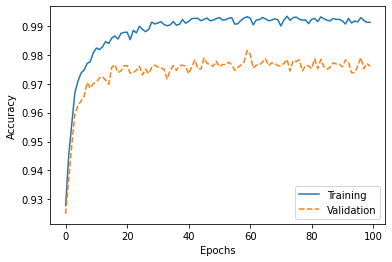

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(nn.epochs), nn.eval_['train_acc'], 
         label='Training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], 
         label='Validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

In [18]:
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test == y_test_pred).astype(np.float) / X_test.shape[0])

print('Test accuracy: %.2f%%' % (acc * 100))

Test accuracy: 97.62%


## Sigmoid + Adam

In [19]:
class MLP(object):
    
    def __init__(self, n_hidden=30, n_hidden2=30,
                 l2=0., epochs=100, minibatch_size=1, eta=0.001,
                 shuffle=True, seed=None, beta1=0.9, beta2=0.999, epsilon=1e-7):

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.n_hidden2 = n_hidden2
        self.l2 = l2
        self.epochs = epochs
        self.minibatch_size = minibatch_size
        self.eta = eta
        self.shuffle = shuffle
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m_dw_h, self.v_dw_h = 0, 0
        self.m_db_h, self.v_db_h = 0, 0
        self.m_dw_h2, self.v_dw_h2 = 0, 0
        self.m_db_h2, self.v_db_h2 = 0, 0
        self.m_dw_out, self.v_dw_out = 0, 0
        self.m_db_out, self.v_db_out = 0, 0

    def _onehot(self, y, n_classes):
        
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, z):

        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def _forward(self, X):

        z_h = np.dot(X, self.w_h) + self.b_h

        a_h = self._sigmoid(z_h)
        
        z_h2 = np.dot(a_h, self.w_h2) + self.b_h2
        
        a_h2 = self._sigmoid(z_h2)

        z_out = np.dot(a_h2, self.w_out) + self.b_out

        a_out = self._sigmoid(z_out)

        return z_h, a_h, z_h2, a_h2, z_out, a_out

    def _cost(self, y_enc, output):

        cost = np.sum(-y_enc * (np.log(output)) - (1. - y_enc) * np.log(1. - output)) + \
                      self.l2 * (np.sum(self.w_h ** 2.) + np.sum(self.w_h2 ** 2.) + np.sum(self.w_out ** 2.))

        return cost

    def predict(self, X):
        
        z_h, a_h, z_h2, a_h2, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        
        n_output = np.unique(y_train).shape[0]
        n_features = X_train.shape[1]

        # Weight initialization

        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1, size=(n_features, self.n_hidden))
        
        self.b_h2 = np.zeros(self.n_hidden2)
        self.w_h2 = self.random.normal(loc=0.0, scale=0.1, size=(self.n_hidden, self.n_hidden2))

        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1, size=(self.n_hidden2, n_output))

        epoch_strlen = len(str(self.epochs))
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        y_train_enc = self._onehot(y_train, n_output)

        for i in range(self.epochs):

            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # forward propagation
                z_h, a_h, z_h2, a_h2, z_out, a_out = self._forward(X_train.iloc[batch_idx])

                # Backpropagation

                delta_out = a_out - y_train_enc[batch_idx]

                sigmoid_derivative_h = a_h * (1. - a_h)
                
                sigmoid_derivative_h2 = a_h2 * (1. - a_h2)

                delta_h2 = (np.dot(delta_out, self.w_out.T) * sigmoid_derivative_h2)
                
                delta_h = (np.dot(delta_h2, self.w_h2.T) * sigmoid_derivative_h)

                grad_w_h = np.dot(X_train.iloc[batch_idx].T, delta_h)
                grad_b_h = np.sum(delta_h, axis=0)
                
                grad_w_h2 = np.dot(a_h.T, delta_h2)
                grad_b_h2 = np.sum(delta_h2, axis=0)

                grad_w_out = np.dot(a_h2.T, delta_out)
                grad_b_out = np.sum(delta_out, axis=0)
                
                self.m_dw_out = self.beta1*self.m_dw_out + (1-self.beta1)*grad_w_out
                self.m_db_out = self.beta1*self.m_db_out + (1-self.beta1)*grad_b_out
                
                self.m_dw_h = self.beta1*self.m_dw_h + (1-self.beta1)*grad_w_h
                self.m_db_h = self.beta1*self.m_db_h + (1-self.beta1)*grad_b_h
                
                self.m_dw_h2 = self.beta1*self.m_dw_h2 + (1-self.beta1)*grad_w_h2
                self.m_db_h2 = self.beta1*self.m_db_h2 + (1-self.beta1)*grad_b_h2
                
                self.v_dw_out = self.beta2*self.v_dw_out + (1-self.beta2)*(grad_w_out**2)
                self.v_db_out = self.beta2*self.v_db_out + (1-self.beta2)*(grad_b_out)
                
                self.v_dw_h = self.beta2*self.v_dw_h + (1-self.beta2)*(grad_w_h**2)
                self.v_db_h = self.beta2*self.v_db_h + (1-self.beta2)*(grad_b_h)
                
                self.v_dw_h2 = self.beta2*self.v_dw_h2 + (1-self.beta2)*(grad_w_h2**2)
                self.v_db_h2 = self.beta2*self.v_db_h2 + (1-self.beta2)*(grad_b_h2)
                
                m_dw_out_corr = self.m_dw_out/(1-self.beta1**i+1)
                m_db_out_corr = self.m_db_out/(1-self.beta1**i+1)
                v_dw_out_corr = self.v_dw_out/(1-self.beta2**i+1)
                v_db_out_corr = self.v_db_out/(1-self.beta2**i+1)
                
                m_dw_h_corr = self.m_dw_h/(1-self.beta1**i+1)
                m_db_h_corr = self.m_db_h/(1-self.beta1**i+1)
                v_dw_h_corr = self.v_dw_h/(1-self.beta2**i+1)
                v_db_h_corr = self.v_db_h/(1-self.beta2**i+1)
                
                m_dw_h2_corr = self.m_dw_h2/(1-self.beta1**i+1)
                m_db_h2_corr = self.m_db_h2/(1-self.beta1**i+1)
                v_dw_h2_corr = self.v_dw_h2/(1-self.beta2**i+1)
                v_db_h2_corr = self.v_db_h2/(1-self.beta2**i+1)
        
                delta_w_h = (m_dw_h_corr/(np.sqrt(np.abs(v_dw_h_corr))+self.epsilon) + self.l2*self.w_h)
                delta_b_h = m_db_h_corr/(np.sqrt(np.abs(v_db_h_corr))+self.epsilon)
                
                delta_w_h2 = (m_dw_h2_corr/(np.sqrt(np.abs(v_dw_h2_corr))+self.epsilon) + self.l2*self.w_h2)
                delta_b_h2 = m_db_h2_corr/(np.sqrt(np.abs(v_db_h2_corr))+self.epsilon)
                
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h
                
                self.w_h2 -= self.eta * delta_w_h2
                self.b_h2 -= self.eta * delta_b_h2

                delta_w_out = (m_dw_out_corr/(np.sqrt(np.abs(v_dw_out_corr))+self.epsilon) + self.l2*self.w_out)
                delta_b_out = m_db_out_corr/(np.sqrt(np.abs(v_db_out_corr))+self.epsilon)
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out
            # Evaluation

            z_h, a_h, z_h2, a_h2, z_out, a_out = self._forward(X_train)
            
            cost = self._cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) / X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) / X_valid.shape[0])

            sys.stdout.write('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost, train_acc*100, valid_acc*100))
            sys.stdout.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

In [20]:
nn = MLP(n_hidden=128, n_hidden2=64, l2=0.1, epochs=100, minibatch_size=100, eta=0.001, shuffle=True, seed=1, beta1=0.9, 
         beta2=0.99, epsilon=1e-8)

In [21]:
%%time
nn.fit(X_train[:55000], y_train[:55000], X_train[55000:], y_train[55000:])

100/100 | Cost: 4283.65 | Train/Valid Acc.: 99.39%/97.56%  Wall time: 8min 43s


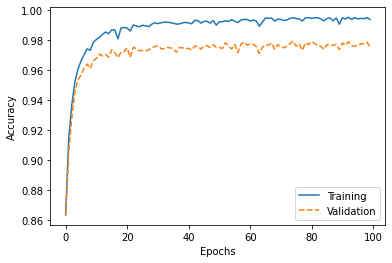

In [22]:
import matplotlib.pyplot as plt
plt.plot(range(nn.epochs), nn.eval_['train_acc'], 
         label='Training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], 
         label='Validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

In [23]:
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test == y_test_pred).astype(np.float) / X_test.shape[0])

print('Test accuracy: %.2f%%' % (acc * 100))

Test accuracy: 97.65%
